<a href="https://colab.research.google.com/github/AmitCosmo/hubble-data/blob/main/parametrization_of_deceleration_parameter_of_f(R%2CT%5Ephi)_gravity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install corner

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,uniform
import time
import corner
import math
import scipy.optimize as op
import requests
# from numpy import *

In [ ]:
# Define the load_data function
def load_data(url):
    response = requests.get(url)
    data = np.loadtxt(response.text.splitlines())
    x, y, yerr = data[:, 0], data[:, 1], data[:, 2]
    return x, y, yerr

In [ ]:
# Define likelihood, prior, and posterior functions
def likelihood(theta, x, y, yerr):
    h0, q0, q1 = theta
    model = h0 * (1+x)**(1+q0)* (1+x**2)**(q1/2)
    inv_sigma2 = 1.0 / (yerr**2)
    return -0.5 * (np.sum((y - model)**2 * inv_sigma2 - np.log(2 * np.pi * yerr**2)))

In [ ]:
def prior(theta):
    h0, q0, q1 = theta
    if 50.0 < h0 < 100.0 and -3.0 < q0 < 3.0 and 0 < q1 < 4.0:
        return 0.0
    return -np.inf

In [ ]:
def posterior(theta, x, y, yerr):
    lp = prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + likelihood(theta, x, y, yerr)

In [ ]:
def Metropolis_Hastings(parameter_init, x, y, yerr, iteration_time):
    result = []
    result.append(parameter_init)
    for t in range(iteration_time):
        step_var = [1, 0.01, 0.06]
        proposal = np.zeros(3)
        for i in range(3):
            proposal[i] = norm.rvs(loc=result[-1][i], scale=step_var[i])
            probability = np.exp(posterior(proposal, x, y, yerr) - posterior(result[-1], x, y, yerr))
            if uniform.rvs() < probability:
                result.append(proposal)
            else:
                result.append(result[-1])
    return np.array(result)

In [ ]:
# Define URLs for the datasets
urls = [
    'https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_46%20%20data%20set.txt',
    'https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/Bao_26%20data%20set.txt'
]

In [ ]:
# Load and process data
hubble_x, hubble_y, hubble_yerr = load_data(urls[0])
bao_x, bao_y, bao_yerr = load_data(urls[1])

In [ ]:
# Initial seeds
h0_ini, q0_ini, q1_ini = 60, 0, 0
initials = [h0_ini, q0_ini, q1_ini]

In [ ]:
# Number of parameter, steps, burn-in phase
ndim = 3
nsteps = 300000
nburn_in = 1000

In [ ]:
start_time = time.time()

In [ ]:
# Calculate and print execution time
execution_time = time.time() - start_time
print("Execution time with steps={} -> {:.3f} seconds".format(nsteps, execution_time))

Execution time with steps=300000 -> 2.948 seconds


In [ ]:
# Run Metropolis-Hastings algorithm
samples_MH = Metropolis_Hastings(initials, hubble_x, hubble_y, hubble_yerr, nsteps)
samples_MH = samples_MH[nburn_in:]

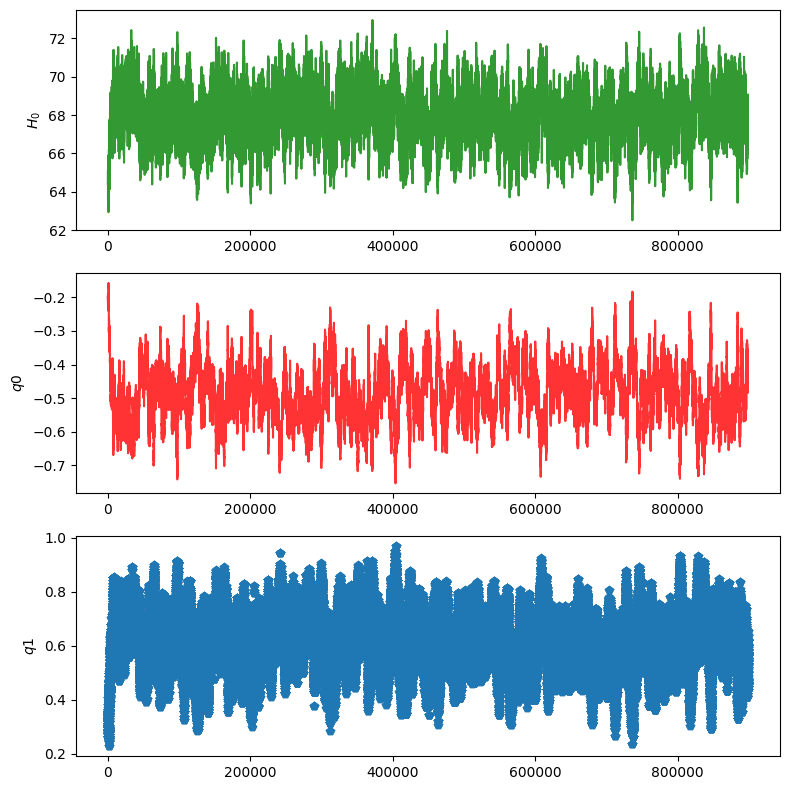

In [ ]:
# Plot the traceplots of the MCMC chains
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
samples = samples_MH.T

# Plot the traceplot of H0
axes[0].plot(samples[0], "g", alpha=0.8)
axes[0].set_ylabel("$H_0$")


# Plot the traceplot of q0
axes[1].plot(samples[1], "r", alpha=0.8)
axes[1].set_ylabel("$q0$")

# Plot the traceplot of q1
axes[2].plot(samples[2], "p", alpha=0.8)
axes[2].set_ylabel("$q1$")

plt.tight_layout()
# plt.savefig("FLCDM_H_31_MH_traces.png")
plt.show()

In [ ]:
# Calculate the percentiles for MCMC results
h0_mcmc, q0_mcmc, q1_mcmc = map(lambda v: (v[1], v[2] - v[1], v[1] - v[0]), zip(*np.percentile(samples_MH, [16, 50, 84], axis=0)))

In [ ]:
# Print MCMC results
print("""MCMC result:
    H0 = {0[0]} +{0[1]} -{0[2]}
    q0 = {1[0]} +{1[1]} -{1[2]}
    q1 = {2[0]} +{2[1]} -{2[2]}
""".format(h0_mcmc, q0_mcmc, q1_mcmc))

MCMC result:
    H0 = 67.95565408381232 +1.248467560806688 -1.2746888436465014
    q0 = -0.48701734100786437 +0.0878450593235629 -0.08282970935892126
    q1 = 0.6178481654683007 +0.09778332801494283 -0.10131563698067658



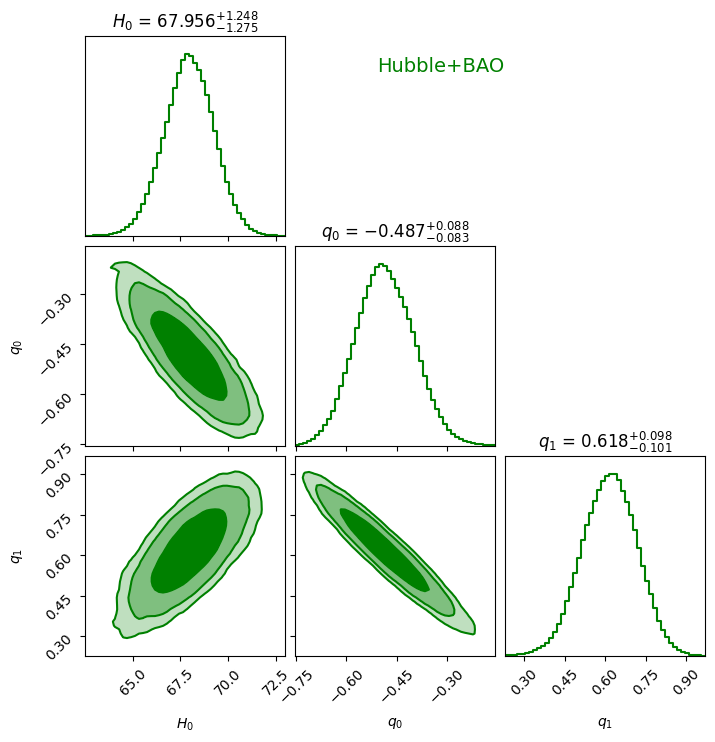

In [ ]:
fig = corner.corner(samples_MH,bins=50,color="g",labels=["$H_0$","$q_0$", "$q_1$"],
                    fill_contours=True,
                    levels=(0.68,0.95,0.99,),
                    title_fmt='.3f',plot_datapoints=False,smooth=True, smooth1d=True, smooth3d=True, show_titles=True, plot_contours=True)

# Get the color of the corner plot
corner_plot_color = "g"  # Replace this with the actual color of your corner plot

# Add the title with the graph's color
plt.figtext(0.6, 0.9, 'Hubble+BAO', ha='center', fontsize=14, color=corner_plot_color)
plt.show()

In [ ]:
! pip install lmfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 6.2 MB/s eta 0:00:00


[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 59
    # variables        = 3
    chi-square         = 27.6593932
    reduced chi-square = 0.49391774
    Akaike info crit   = -38.6967514
    Bayesian info crit = -32.4641390
    R-squared          = 0.99975095
[[Variables]]
    h0:  67.4607360 +/- 0.83869048 (1.24%) (init = 70)
    q0: -0.45681531 +/- 0.04770074 (10.44%) (init = 0)
    q1:  0.58978139 +/- 0.05352930 (9.08%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(q0, q1) = -0.9606
    C(h0, q0) = -0.9151
    C(h0, q1) = +0.8139


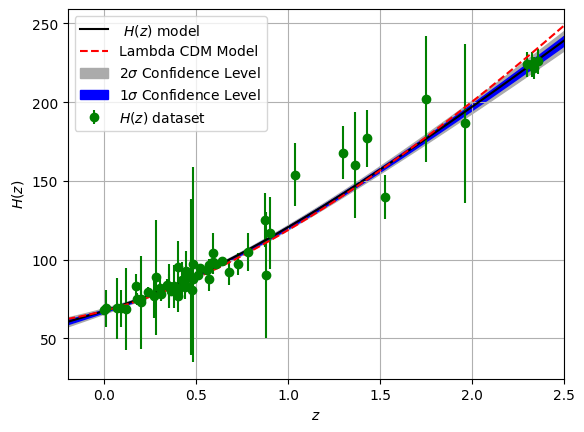

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import ExpressionModel

# Load additional datasets
hubble_data = np.loadtxt('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_46%20%20data%20set.txt', unpack=True)
bao_data = np.loadtxt('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/BAO_15.txt', unpack=True)

# Extract data from additional datasets
hubble_z = hubble_data[0]
hubble_H = hubble_data[1]
hubble_err = hubble_data[2]

bao_z = bao_data[0]
bao_H = bao_data[1]
bao_err = bao_data[2]

# Combine all datasets
all_z = np.concatenate((hubble_z, bao_z))
all_H = np.concatenate((hubble_H, bao_H))
all_err = np.concatenate((hubble_err, bao_err))

# Create a new lmfit Model object for the modified function
mod = ExpressionModel('h0 * (1 + x)**(1 + q0) * (1 + x**2)**(q1/2)')

# Set initial parameter values
initial_h0_value = 70
initial_q0_value = 0
initial_q1_value = 0

pars = mod.make_params(h0=initial_h0_value, q0=initial_q0_value, q1=initial_q1_value)

# Perform the fit using combined datasets
result = mod.fit(all_H, pars, x=all_z, weights=1.0/all_err)

# Print the fit report
print(result.fit_report())

# Generate predictions and uncertainties for plotting
xfine = np.arange(-0.2, 2.5001, 0.001)
ypred = result.eval(x=xfine)
dely = result.eval_uncertainty(x=xfine, sigma=1)

# Generate the Lambda CDM predicted values
def lambda_cdm(z, hubble_constant):
    omega_m = 0.3  # Example value for matter density parameter in Lambda CDM model
    omega_lambda = 1 - omega_m
    return hubble_constant * np.sqrt(omega_m * (1 + z)**3 + omega_lambda)

lambda_cdm_H = lambda_cdm(xfine, result.params['h0'].value)

# Plot the data and the best-fitted line
plt.errorbar(all_z, all_H, all_err, fmt='go', label='$H(z)$ dataset')
plt.plot(xfine, ypred, 'k-', label=' $H(z)$ model')

# Plot the Lambda CDM line
plt.plot(xfine, lambda_cdm_H, 'r--', label='Lambda CDM Model')

# Fill the confidence intervals
plt.fill_between(xfine, ypred-2*dely, ypred+2*dely, color="#ABABAB", label="$2\sigma$ Confidence Level")
plt.fill_between(xfine, ypred-dely, ypred+dely, color="blue", label="$1\sigma$ Confidence Level")

plt.xlim(-0.2, 2.5)
plt.grid(True)
plt.xlabel('$z$')
plt.ylabel('$H(z)$')
plt.legend(loc="upper left")
plt.show()


Best-fit Parameters:
h0 = 65.97622636210234
q0 = -0.38698749118835296
q1 = 0.5221120162598141


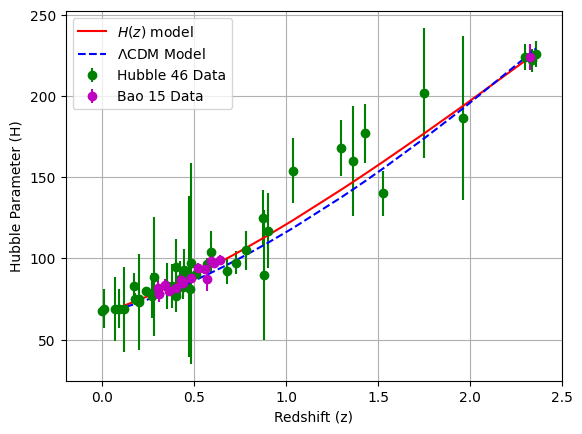

In [ ]:
import numpy as np
from lmfit import Model
import matplotlib.pyplot as plt

# Load the primary Hubble dataset with errors (z: redshift, H: Hubble parameter, err: error)
data = np.loadtxt('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_55%20data%20set.txt', unpack=True)

z = data[0]
H = data[1]
err = data[2]

# Load and process additional datasets
hubble_data = np.loadtxt('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_46%20%20data%20set.txt', unpack=True)
bao_data = np.loadtxt('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/BAO_15.txt', unpack=True)

# Extract data from additional datasets
hubble_z = hubble_data[0]
hubble_H = hubble_data[1]
hubble_err = hubble_data[2]

bao_z = bao_data[0]
bao_H = bao_data[1]
bao_err = bao_data[2]

# Define the function to be fitted
def hubble_func(z, h0, q0, q1):
    return h0 * (1+z)**(1+q0)* (1+z**2)**(q1/2)

# Lambda CDM model function
def lambda_cdm(z, hubble_constant):
    omega_m = 0.3  # Example value for matter density parameter in Lambda CDM model
    omega_lambda = 1 - omega_m
    return hubble_constant * np.sqrt(omega_m * (1 + z)**3 + omega_lambda)

# Create an lmfit Model object for the hubble_func
model = Model(hubble_func)

# Set initial parameter values for the hubble_func
params = model.make_params(h0=70, q0=0, q1=0)

# Perform the fit using the primary dataset
result = model.fit(H, params, z=z, weights=1/err)

# Get the best-fit parameters
best_fit_parameters = result.params

# ... (Rest of your fitting and plotting code remains unchanged)
# Print the best-fit parameters
print("Best-fit Parameters:")
print("h0 =", best_fit_parameters['h0'].value)
print("q0 =", best_fit_parameters['q0'].value)
print("q1 =", best_fit_parameters['q1'].value)

# Plot additional datasets with error bars
plt.errorbar(hubble_z, hubble_H, yerr=hubble_err, fmt='go', label='Hubble 46 Data')
plt.errorbar(bao_z, bao_H, yerr=bao_err, fmt='mo', label='Bao 15 Data')

# ... (Rest of your plotting code remains unchanged)
# Generate the predicted values from the best-fit parameters for hubble_func
predicted_H = model.eval(best_fit_parameters, z=z)

# Plot the best-fit line for hubble_func
plt.plot(z, predicted_H, 'r-', label='$H(z)$ model')

# Generate the Lambda CDM predicted values
lambda_cdm_H = lambda_cdm(z, best_fit_parameters['h0'].value)

# Plot the Lambda CDM line
plt.plot(z, lambda_cdm_H, 'b--', label='$\Lambda$CDM Model')

# Add labels and legend
plt.xlim(-0.2,2.5)
plt.xlabel('Redshift (z)')
plt.ylabel('Hubble Parameter (H)')
plt.legend()
plt.grid(True)
# Show the plot
plt.show()


Best-fit Parameters:
h0 = 67.84195538411942
q0 = -0.4765105650910235
q1 = 0.6074320528192863


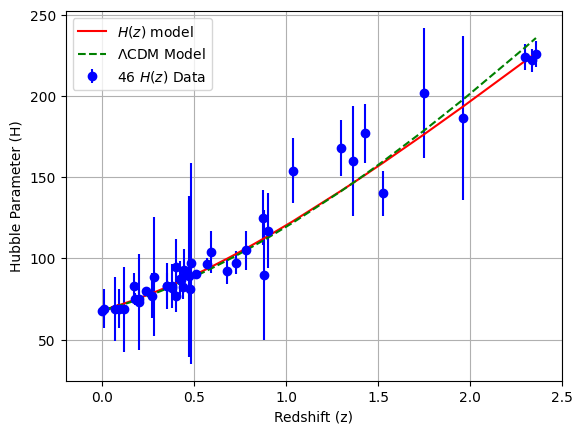

In [ ]:
import numpy as np
from lmfit import Model
import matplotlib.pyplot as plt

# Load the Hubble dataset with errors (z: redshift, H: Hubble parameter, err: error)
data = np.loadtxt('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_46%20%20data%20set.txt', unpack=True)

z = data[0]
H = data[1]
err = data[2]

# Define the function to be fitted
def hubble_func(z, h0, q0, q1):
    return h0 * (1+z)**(1+q0)* (1+z**2)**(q1/2)

# Lambda CDM model function
def lambda_cdm(z, hubble_constant):
    omega_m = 0.3  # Example value for matter density parameter in Lambda CDM model
    omega_lambda = 1 - omega_m
    return hubble_constant * np.sqrt(omega_m * (1 + z)**3 + omega_lambda)

# Create an lmfit Model object for the hubble_func
model = Model(hubble_func)

# Set initial parameter values for the hubble_func
params = model.make_params(h0=70, q0=0, q1=0)

# Perform the fit
result = model.fit(H, params, z=z, weights=1/err)

# Get the best-fit parameters
best_fit_parameters = result.params

# Print the best-fit parameters
print("Best-fit Parameters:")
print("h0 =", best_fit_parameters['h0'].value)
print("q0 =", best_fit_parameters['q0'].value)
print("q1 =", best_fit_parameters['q1'].value)

# Plot the data with error bars
plt.errorbar(z, H, yerr=err, fmt='bo', label='$46$ $H(z)$ Data')

# Generate the predicted values from the best-fit parameters for hubble_func
predicted_H = model.eval(best_fit_parameters, z=z)

# Plot the best-fit line for hubble_func
plt.plot(z, predicted_H, 'r-', label='$H(z)$ model')

# Generate the Lambda CDM predicted values
lambda_cdm_H = lambda_cdm(z, best_fit_parameters['h0'].value)

# Plot the Lambda CDM line
plt.plot(z, lambda_cdm_H, 'g--', label='$\Lambda$CDM Model')

# Add labels and legend
plt.xlim(-0.2,2.5)
plt.xlabel('Redshift (z)')
plt.ylabel('Hubble Parameter (H)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
!pip install corner

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,uniform
import time
import corner
import math
import scipy.optimize as op
# from numpy import *

In [ ]:
x,y,yerr = np.loadtxt('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_46%20%20data%20set.txt', unpack=True)

In [ ]:
#Initial seeds
h0_ini,q0_ini,q1_ini=70,0,0

#Define log-Likelihood Function

def likelihood(theta, x, y, yerr):
    h0, q0, q1 = theta
    model = h0 * (1+x)**(1+q0)* (1+x**2)**(q1/2)
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(6.28*inv_sigma2)))

In [ ]:
#Define Prior Function
def prior(theta):
    h0, q0, q1= theta
    if 50.0< h0 < 100.0 and -3.0 < q0 < 3.0 and 0 < q1 < 4.0:
        return 0.0
    return -np.inf

#Degine Posterior Function
def posterior(theta, x, y, yerr):
    lp = prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp + likelihood(theta, x, y, yerr))

In [ ]:
#Define number of parameter, steps, burn-in phase
ndim=3
nsteps=300000
nburn_in=1000

initials=h0_ini,q0_ini,q1_ini

In [ ]:
start_time = time.time()


#Define Metropolis-Hastings Function
def Metropolis_Hastings(parameter_init, iteration_time):
    result = []
    result.append(parameter_init)
    for t in range(iteration_time):
        step_var = [1, 0.01, 0.06]
        proposal = np.zeros(3)
        for i in range(3):
            proposal[i] = norm.rvs(loc=result[-1][i], scale=step_var[i])
            probability = np.exp(posterior(proposal,x,y,yerr) - posterior(result[-1],x,y,yerr))
            if (uniform.rvs() < probability):
                result.append(proposal)
            else:
                result.append(result[-1])
    return (result)

result = Metropolis_Hastings(initials, nsteps)

result = result[nburn_in:]
a_result = np.zeros(nburn_in)
b_result = np.zeros(nburn_in)
samples_MH=np.array(result)
h0_mcmc, q0_mcmc, q1_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples_MH,
                       [16, 50, 84],axis=0)))

print("----------------------------------------------------------------------\n")
print("Execution time with steps=%s------> %6.3f seconds" %
      (nsteps,(time.time() - start_time)))
print("----------------------------------------------------------------------\n")

----------------------------------------------------------------------

Execution time with steps=300000------> 181.272 seconds
----------------------------------------------------------------------



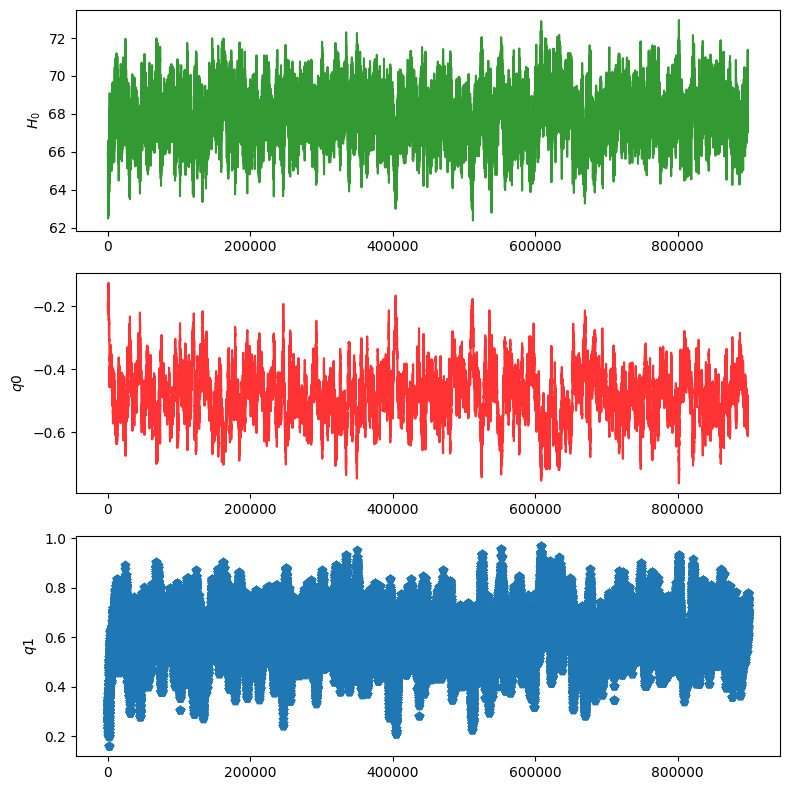

In [ ]:
# Plot the traceplots of the MCMC chains
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
samples = samples_MH.T

# Plot the traceplot of H0
axes[0].plot(samples[0], "g", alpha=0.8)
axes[0].set_ylabel("$H_0$")


# Plot the traceplot of q0
axes[1].plot(samples[1], "r", alpha=0.8)
axes[1].set_ylabel("$q0$")

# Plot the traceplot of q1
axes[2].plot(samples[2], "p", alpha=0.8)
axes[2].set_ylabel("$q1$")

plt.tight_layout()
# plt.savefig("FLCDM_H_31_MH_traces.png")
plt.show()

In [ ]:
print("""MCMC result:
    H0 = {0[0]} +{0[1]} -{0[2]}
    q0 = {2[0]} +{2[1]} -{2[2]}
    q1 = {4[0]} +{4[1]} -{4[2]}
""".format(h0_mcmc, h0_ini, q0_mcmc, q0_ini, q1_mcmc, q1_ini))

MCMC result:
    H0 = 67.88513592380579 +1.255431183603875 -1.2580606178466809
    q0 = -0.48037496277363445 +0.08359429292369674 -0.08486416821026066
    q1 = 0.6113689109660836 +0.09919333217174009 -0.0972331967592509



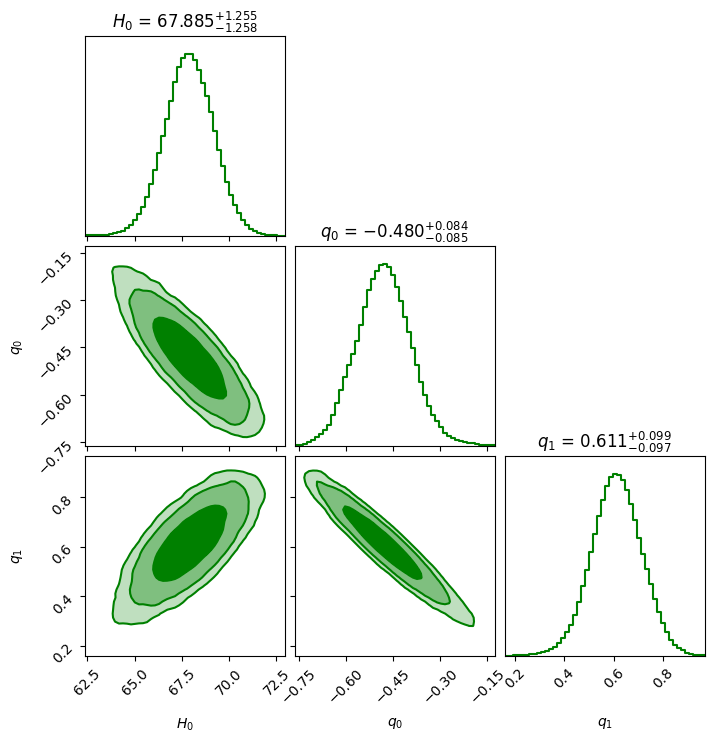

In [ ]:
fig = corner.corner(samples_MH,bins=50,color="g",labels=["$H_0$","$q_0$", "$q_1$"],
                    fill_contours=True,
                    levels=(0.68,0.95,0.99,),
                    title_fmt='.3f',plot_datapoints=False,smooth=True, smooth1d=True, smooth3d=True, show_titles=True, plot_contours=True)
#fig.savefig("FLCDM_H_46_MH.png")